# Generate training data

256×169 samples</p>
### Change demand
timestep = 1h, 1 week ->169 timesteps in total</p>
at every timestep, change the nodal demand</p>
### Change topology
Randomly cut the connectivity between two pipes, but preserving the connectivity between each node in the network and source. ->256 topology

### Try single timestep

In [1]:
import wntr
import networkx as nx
import scipy.sparse as sp
import numpy as np 
import random
import tqdm
import os 
import matplotlib.pyplot as plt
import itertools
from collections import Counter 
import networkx as nx
import copy
import pandas as pd
import tensorflow_gnn as tfgnn
import tensorflow as tf
from sklearn.preprocessing import StandardScaler
import seaborn as sns

In [2]:
def get_removable_links(inp_file):
    wn = wntr.network.WaterNetworkModel(inp_file)
    removable_links = []
    G = wn.to_graph(wn)
    # Store not-deadend pipes to be removed
    for _, link in wn.links():
        if (link.link_type == 'Pipe' and
            link.start_node.node_type == 'Junction' and
            link.end_node.node_type == 'Junction' and
            G.degree[link.start_node.name] > 1 and
            G.degree[link.end_node.name] > 1):
            removable_links.append(link)
    # To find pairs of links that can be removed together while keeping the network graph connected
    removable_pairs = []
    for (link1, link2) in itertools.combinations(removable_links, 2):
        wnr = copy.deepcopy(wn)  #create a new reference to the same object
        wnr.remove_link(link1)
        wnr.remove_link(link2)
        Gr = wnr.to_graph().to_undirected()
        if nx.is_connected(Gr):
            removable_pairs.append((link1, link2))

    return removable_links, removable_pairs


In [3]:
network = 'ASnet2'
inp_file = network + '.inp'
wn = wntr.network.WaterNetworkModel(inp_file)

# get removable links
removable_links, removable_pairs = get_removable_links(inp_file)
num_nodes = wn.num_nodes
num_links = wn.num_links
num_time = int(wn.options.time.duration / wn.options.time.report_timestep + 1)

In [4]:
n_sims = 128
#𝑉_𝑖=[ 𝐼_𝑖^𝑑, 𝑞_𝑖, 𝐼_𝑖^𝑚,𝐻_𝑖^∗ ] 
#𝐸_𝑝=[𝑖,𝑗,𝑐_𝑝]
#Create data matrix
A = np.zeros((n_sims , num_links*num_time, 3))
B = np.zeros((n_sims , num_nodes*num_time, 6))
U = np.zeros((n_sims , num_nodes*num_time, 1))



# Store the randomly chosen pairs of removable links
links2remove = random.sample(removable_pairs, n_sims)

## Measurement when fully-supervised
measurement_fully = []
monitor = ['1', '5', '11','15','19','22','25',  '37', '44','51']

In [5]:
for sim in range(n_sims):
    wn = wntr.network.WaterNetworkModel(inp_file)  # reset value
    wn.options.hydraulic.demand_model = 'DD' #dynamic demand model

    i = 0
    for _, node in wn.nodes():
        node.id = i
        i += 1

    if sim != 0:
        (link1, link2) = links2remove[sim - 1]
        wn.remove_link(link1)
        wn.remove_link(link2)

    i = 0
    for _, link in wn.links():
        A[sim, i, 0] = link.start_node.id
        A[sim, i, 1] = link.end_node.id
        if link.link_type=='Pipe':
            A[sim, i, 2] = 1/(10.667*link.length/link.roughness**1.852/link.diameter**4.871)
            i+=1
        elif link.link_type=='Pump':
            A[sim, i, 2] = 1        
        elif link.link_type=='Valve':
            A[sim, i, 2] = 2        
        else:
            print('Other types of links exist.')
        i+=1

    results = wntr.sim.EpanetSimulator(wn).run_sim(version=2.0)
    head = results.node['head']
    demand = results.node['demand']
    demand = np.maximum(demand, 0)
    
    ### Produce datas for multiple timestep
    #### Time step
    index_values = head.index.values
    np.random.seed(42)
    Time_step = np.random.choice(index_values, size=num_time, replace=False)
    
    repeated_timestep = pd.Series(Time_step).repeat(num_nodes).reset_index(drop=True)
    Time_indicator = pd.DataFrame({'Timestep': repeated_timestep})
    Time_indicator = Time_indicator.squeeze()
    
    #### Demand
    demand_s = demand.loc[Time_step]
    demand_s = demand_s.values.flatten()
    #### Head
    head_s = head.loc[Time_step]
    head_s = head_s.values.flatten()
    #### Node indicator (the number of the node)
    Node_indicator = np.tile(np.arange(1, num_nodes+1), num_time)
        # Measurement when fully-supervised
    measurement_fully = Node_indicator
    #### Junction indicator (if the node is not a reservoir, junction indicator = 1)
    Nd_single = np.array([1 if node.node_type == 'Junction' else 0 for _, node in wn.nodes()])
    Nd = np.tile(Nd_single,num_time)
    Nd = Nd.squeeze()
    #### Measurement indicator (if the node has head, measurement indicator = 0) 
    Nh_single = np.array([0 if node.node_type=='Junction' and node.name not in monitor else 1 for _,node in wn.nodes()])
    Nh = np.tile(Nh_single,num_time)
    Nh = Nh.squeeze()
    ###
    
    ### Node
    B[sim, :, 0] = Time_indicator
    B[sim, :, 1] = Node_indicator
    B[sim, :, 2] = Nd
    B[sim, :, 3] = demand_s
    B[sim, :, 4] = Nh
    B[sim, :, 5] = Nh* head_s
    ###

    U[sim, :, 0] = head_s

In [6]:
### Edge
A_re = A[:, :num_links, :]  # Extract the first 65 rows along the second axis

# Repeat the 65 rows to cover the entire second axis
A_re = np.tile(A_re, (1, num_time, 1))


### Change 3-d array to DataFrame

In [7]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A_re.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A_re.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
graph_df = pd.DataFrame(U_2d)

In [8]:
graph_df.rename(columns={0: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

## Scale the data

In [11]:

# Edge
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
column_to_scale = 'loss_co'

## Fit and transform the selected column
edge_df[column_to_scale] = scaler.fit_transform(edge_df[[column_to_scale]])
#
# Node
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['demand', 'measurement']

# Fit and transform the selected columns
node_df[columns_to_scale] = scaler.fit_transform(node_df[columns_to_scale])
#

# Graph
## Create a StandardScaler object
scaler = StandardScaler()

## Select the column to scale
columns_to_scale = ['head']

# Fit and transform the selected columns
graph_df[columns_to_scale] = scaler.fit_transform(graph_df[columns_to_scale])

In [12]:
test_edge_df = edge_df[n_sims * num_links * (num_time - 34):]
test_node_df = node_df[n_sims * num_nodes * (num_time - 34):]
test_graph_df = graph_df[n_sims * num_nodes * (num_time - 34):]

train_edge_df = edge_df[:n_sims * num_links * (num_time - 100)]
train_node_df = node_df[:n_sims * num_nodes * (num_time - 100)]
train_graph_df = graph_df[:n_sims * num_nodes * (num_time - 100)]

vali_edge_df = edge_df[n_sims * num_links * (num_time - 67):n_sims * num_links * (num_time - 34)]
vali_node_df = node_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]
vali_graph_df = graph_df[n_sims * num_nodes * (num_time - 67):n_sims * num_nodes * (num_time - 34)]

In [13]:
def create_graph_tensor(node_df, edge_df,graph_df):
    graph_tensor = tfgnn.GraphTensor.from_pieces(

        node_sets={
            "node": tfgnn.NodeSet.from_fields(
                sizes=[len(node_df)],
                features={
                   # 'Node_indicator':np.array(node_df['Node_indicator'], dtype='int32').reshape(len(node_df),1),
                    'Junction_in':np.array(node_df['Junction_in'], dtype='int32').reshape(len(node_df),1),
                    'demand': np.array(node_df['demand'], dtype='float32').reshape(len(node_df),1),
                    'Measurement_in': np.array(node_df['Measurement_in'], dtype='int32').reshape(len(node_df),1),
                    'measurement': np.array(node_df['measurement'], dtype='float32').reshape(len(node_df),1),
                    'head': np.array(graph_df['head'], dtype='float32').reshape(len(graph_df),1)
                }
            )
        },
        edge_sets={
            "link": tfgnn.EdgeSet.from_fields(
                sizes=[len(edge_df)],
                features={
                    'loss_co': np.array(edge_df['loss_co'], dtype='float32').reshape(len(edge_df),1),
                },
                adjacency=tfgnn.Adjacency.from_indices(
                                          source=("node", np.array(edge_df['source'], dtype='int32')),
                                          target=("node", np.array(edge_df['target'], dtype='int32')),
                                      ))
        }
    )

    return graph_tensor


In [14]:
full_tensor = create_graph_tensor(node_df, edge_df,graph_df)
train_tensor = create_graph_tensor(train_node_df, train_edge_df,train_graph_df)
test_tensor = create_graph_tensor(test_node_df, test_edge_df, test_graph_df)
vali_tensor = create_graph_tensor(vali_node_df, vali_edge_df, vali_graph_df)

split off ‘head’ as our target (label).

In [15]:
def node_batch_merge(graph):
    graph = graph.merge_batch_to_components()
    node_features = graph.node_sets['node'].get_features_dict()
    edge_features = graph.edge_sets['link'].get_features_dict()
    
    label = node_features.pop('head')
    print(label)
    new_graph = graph.replace_features(node_sets={'node': node_features}, edge_sets={'link': edge_features})
    
    return new_graph, label


     
def create_dataset(graph, function):
    dataset = tf.data.Dataset.from_tensors(graph)
    dataset = dataset.batch(32)
    return dataset.map(function)

### Train dataset

In [16]:
full_node_dataset = create_dataset(full_tensor, node_batch_merge)
train_node_dataset = create_dataset(train_tensor, node_batch_merge)
test_node_dataset = create_dataset(test_tensor, node_batch_merge)
vali_node_dataset = create_dataset(vali_tensor, node_batch_merge)

Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)
Tensor("Reshape_5:0", shape=(None, 1), dtype=float32)


# Model Building

## Build model inputs

In [17]:
graph_spec = train_node_dataset.element_spec[0]
input_graph = tf.keras.layers.Input(type_spec=graph_spec)

In [18]:
def set_initial_node_state(node_set, node_set_name):
    features = [
        #tf.keras.layers.Dense(32, activation="relu")(node_set['Node_indicator']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Junction_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['demand']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['Measurement_in']),
        tf.keras.layers.Dense(32, activation=tf.nn.leaky_relu)(node_set['measurement']),
    ]
    return tf.keras.layers.Concatenate()(features)


def set_initial_edge_state(edge_set, edge_set_name):
    features = [
        tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['loss_co']),
        #tf.keras.layers.Dense(32, activation="leaky_relu")(edge_set['flowrate']),
    ]
    return tf.keras.layers.Concatenate()(features)




In [19]:
graph = tfgnn.keras.layers.MapFeatures(node_sets_fn=set_initial_node_state,
                                       edge_sets_fn=set_initial_edge_state)(input_graph)

In [21]:
def dense_layer(units=32, l2_reg=5e-4, dropout=0.25, activation='tf.nn.leaky_relu'):
    regularizer = tf.keras.regularizers.l2(l2_reg)
    return tf.keras.Sequential([
        tf.keras.layers.Dense(units, kernel_initializer='glorot_normal',kernel_regularizer=regularizer, bias_regularizer=regularizer),
        tf.keras.layers.Dropout(dropout)
    ])


### Compile

In [22]:
graph_updates = 6
l2_reg = 5e-4
regularizer = tf.keras.regularizers.l2(l2_reg)
for i in range(graph_updates):
    graph = tfgnn.keras.layers.GraphUpdate(
        node_sets={
            'node':
            tfgnn.keras.layers.NodeSetUpdate(
                {
                    'link':
                    tfgnn.keras.layers.SimpleConv(message_fn=dense_layer(128),
                                                  reduce_type="mean",
                                                  sender_edge_feature=tfgnn.HIDDEN_STATE,
                                                  receiver_tag=tfgnn.TARGET)
                }, tfgnn.keras.layers.NextStateFromConcat(dense_layer(64)))
        })(graph)
    dense1 = tf.keras.layers.Dense(128,activation=tf.nn.leaky_relu)(graph.node_sets["node"][tfgnn.HIDDEN_STATE])
    dense2 = tf.keras.layers.Dense(64)(dense1)
    dense3 = tf.keras.layers.Dense(1)(dense2)

In [23]:
node_model = tf.keras.Model(input_graph, dense3)
node_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
                   loss='mean_squared_error',
                   metrics=['mean_squared_error'])
node_model.summary()


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [()]                      0         
                                                                 
 map_features (MapFeatures)  ()                        320       
                                                                 
 graph_update (GraphUpdate)  ()                        53440     
                                                                 
 graph_update_1 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_2 (GraphUpdate  ()                       32960     
 )                                                               
                                                                 
 graph_update_3 (GraphUpdate  ()                       32960 

### Train model

In [24]:
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                      mode='min',
                                      verbose=1,
                                      patience=10,
                                      restore_best_weights=True)

node_model.fit(train_node_dataset.repeat(),
               validation_data=vali_node_dataset,
               steps_per_epoch=10,
               epochs=200,
               callbacks=[es])

Epoch 1/200
10/10 [==============================] - 107s 10s/step - loss: 1.5864 - mean_squared_error: 0.9067 - val_loss: 1.4386 - val_mean_squared_error: 0.8223
Epoch 2/200
10/10 [==============================] - 102s 10s/step - loss: 1.4012 - mean_squared_error: 0.8317 - val_loss: 1.3160 - val_mean_squared_error: 0.8004
Epoch 3/200
10/10 [==============================] - 104s 10s/step - loss: 1.2887 - mean_squared_error: 0.8122 - val_loss: 1.2184 - val_mean_squared_error: 0.7868
Epoch 4/200
10/10 [==============================] - 130s 13s/step - loss: 1.1981 - mean_squared_error: 0.7987 - val_loss: 1.1386 - val_mean_squared_error: 0.7759
Epoch 5/200
10/10 [==============================] - 127s 13s/step - loss: 1.1233 - mean_squared_error: 0.7870 - val_loss: 1.0707 - val_mean_squared_error: 0.7647
Epoch 6/200
10/10 [==============================] - 120s 12s/step - loss: 1.0610 - mean_squared_error: 0.7766 - val_loss: 1.0167 - val_mean_squared_error: 0.7570
Epoch 7/200
10/10 [===

KeyboardInterrupt: 

### Evaluate model

In [25]:
eval_result = node_model.evaluate(test_node_dataset)
print(dict(zip(node_model.metrics_names, eval_result)))

1/1 [==============================] - 1s 998ms/step - loss: 0.7231 - mean_squared_error: 0.7042
{'loss': 0.7231361269950867, 'mean_squared_error': 0.7042349576950073}


In [26]:
predictions = pd.DataFrame(node_model.predict(full_node_dataset))
print(predictions)

1/1 [==============================] - 5s 5s/step
                0
0        0.270740
1       -0.406472
2       -0.452618
3       -0.796126
4       -0.129600
...           ...
1103227  0.780556
1103228  0.046724
1103229  0.046724
1103230  0.046724
1103231  2.403876

[1103232 rows x 1 columns]


In [27]:
array_3d_shape = B.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
B_2d = B.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
node_df = pd.DataFrame(B_2d)

array_3d_shape = A_re.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
A_2d = A_re.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
edge_df = pd.DataFrame(A_2d)

array_3d_shape = U.shape
new_shape = (array_3d_shape[0]* array_3d_shape[1] ,array_3d_shape[2])

# Reshaping the 3-dimensional array into a 2-dimensional array
U_2d = U.reshape(new_shape)

# Converting the 2-dimensional array into a DataFrame
graph_df = pd.DataFrame(U_2d)

graph_df.rename(columns={0: 'head'},inplace=True)
edge_df.rename(columns={0: 'source', 1: 'target', 2: 'loss_co'},inplace=True)
node_df.rename(columns={0:'Time_indicator', 1: 'Node_indicator', 2:'Junction_in',3: 'demand', 4: 'Measurement_in',5:'measurement'},inplace=True)

In [28]:
correlation = graph_df['head'].corr(predictions[0])
print(correlation)

0.5438874429588254


In [29]:
mean_n = graph_df['head'].mean()
std_n = graph_df['head'].std()
Pre = (predictions *std_n)+mean_n
print(Pre)
correlation = graph_df['head'].corr(Pre[0])
residuals =  graph_df['head']- (Pre[0])
print(correlation)
print(residuals)

                  0
0        398.002137
1        397.676574
2        397.654390
3        397.489251
4        397.809678
...             ...
1103227  398.247227
1103228  397.894444
1103229  397.894444
1103230  397.894444
1103231  399.027624

[1103232 rows x 1 columns]
0.5438874429588264
0         -0.203523
1          0.121430
2          0.144072
3          0.316413
4         -0.009660
             ...   
1103227    0.258968
1103228    0.545986
1103229    0.477443
1103230    0.477443
1103231   -0.027593
Length: 1103232, dtype: float64


In [30]:
Pre.to_csv('pre_10.csv')

In [32]:
squared_errors = (graph_df['head'] - Pre[0]) ** 2
    
# Calculate the mean of the squared errors
mse = np.mean(squared_errors)
print(mse)

0.16279653302235597


In [33]:
ana = pd.DataFrame({
    'node':node_df['Node_indicator'],
    'predictions': Pre[0],
    'residuals': residuals
})


In [35]:
float_monitor = [float(num_str) for num_str in monitor]

In [36]:
PRE = ana[ana['node'].isin(float_monitor)]['predictions']

RESI = ana[ana['node'].isin(float_monitor)]['residuals']

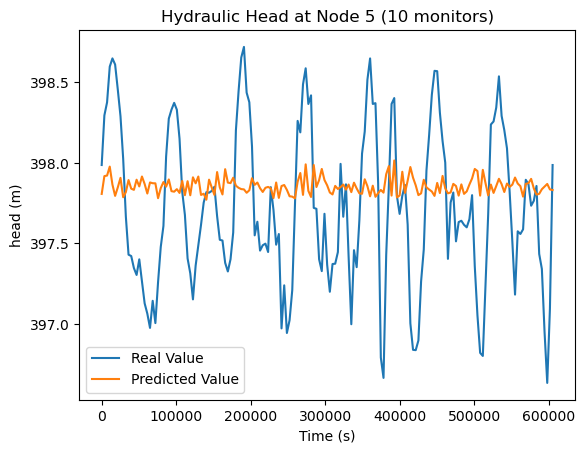

In [59]:
Pre_array =  np.array(Pre).reshape((-1, 51,128))
Pre_array = np.mean(Pre_array, axis=2)
Pre_ana = pd.DataFrame(Pre_array, columns=['Node ' + str(i+1) for i in range(51)])

head_at_node5 = head.loc[:,'5']
ax = head_at_node5.plot()
ax.set_xlabel("Time (s)")
ax.set_ylabel("head (m)")

Pre_ana = Pre_ana.set_index(head.index)

Pre_ana['Node 5'].plot(ax=ax)
plt.title('Hydraulic Head at Node 5 (10 monitors)')
plt.legend(['Real Value', 'Predicted Value'])
plt.savefig('Hydraulic Head at Node 5 (10 monitors).png')
plt.show()

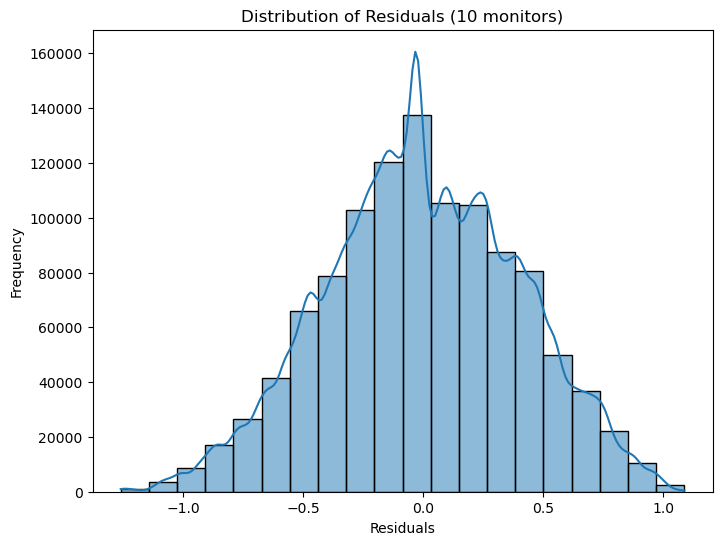

In [40]:
plt.figure(figsize=(8, 6))  # Adjust the figure size if needed
sns.histplot(residuals, kde=True, bins=20)  # kde=True adds a Kernel Density Estimation curve
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Distribution of Residuals (10 monitors)')
plt.savefig('Distribution of Residuals (10 monitors).png')
plt.show()

In [41]:
RESI = ana[ana['node'].isin(float_monitor)]['residuals']
Other_RESI = ana[~ana['node'].isin(float_monitor)]['residuals']

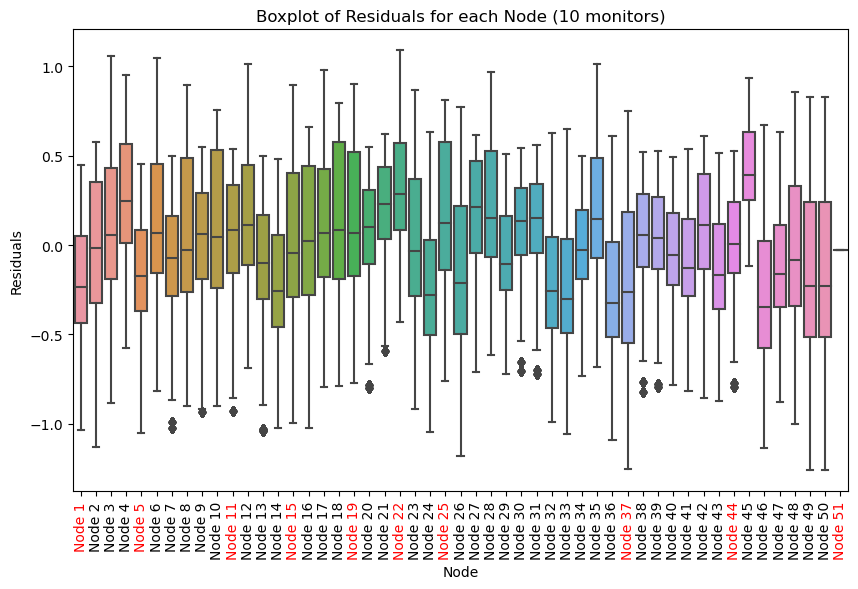

In [43]:
residuals_array =  np.array(residuals).reshape((-1, 51))
reshaped_ana = pd.DataFrame(residuals_array, columns=['Node ' + str(i+1) for i in range(51)])

plt.figure(figsize=(10, 6))  
sns.boxplot(data=reshaped_ana)
plt.xlabel('Node')
plt.ylabel('Residuals')
plt.title('Boxplot of Residuals for each Node (10 monitors)')

unique_nodes = [float(node.split()[1]) for node in reshaped_ana.columns]
# Set the color map for the boxplot
colors = ['red' if node in float_monitor else 'black' for node in unique_nodes]

# Apply the color map to the boxplot
for i, artist in enumerate(plt.gca().artists):
    col = colors[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('white') 

for tick, color in zip(plt.gca().get_xticklabels(), colors):
    tick.set_color(color)
plt.xticks(rotation=90)
plt.xticks(range(len(reshaped_ana.columns)), reshaped_ana.columns, rotation=90)

# Show the plot
plt.savefig('Boxplot of Residuals for each Node (10 monitors).png')
plt.show()

In [46]:
RESI = np.array(RESI).reshape((-1, 10))
RESI_df = pd.DataFrame(RESI, columns=['Node ' + str(i) for i in float_monitor])

filtered_indices = [i for i in range(1, 52) if i not in float_monitor]
Other_RESI = np.array(Other_RESI).reshape((-1, 41))
Other_RESI_df = pd.DataFrame(Other_RESI, columns=['Node ' + str(i) for i in filtered_indices])

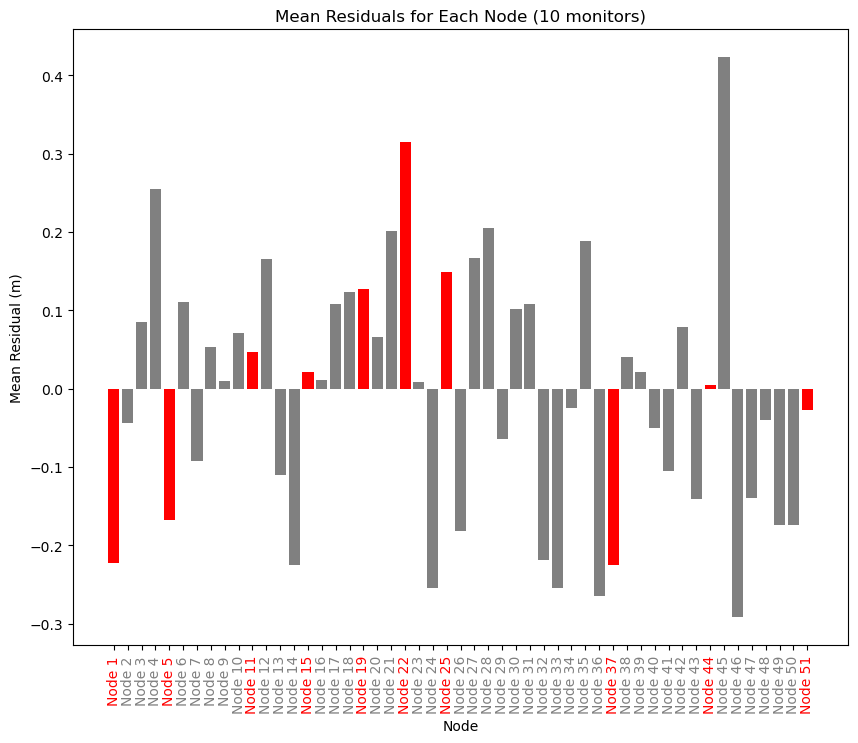

In [54]:

# Assuming 'float_monitor' contains the nodes you want to exclude from the range
float_monitor = [1.0, 5.0, 11.0, 15.0, 19.0, 22.0, 25.0, 37.0, 44.0, 51.0]

# Get the indices in range(51) but not in 'float_monitor'
filtered_indices = [i for i in range(1, 52) if i not in float_monitor]

# Calculate mean residuals and set the color for each node
mean_residuals = reshaped_ana.mean()
colors = ['grey' if int(node.split()[1]) in filtered_indices else 'red' for node in mean_residuals.index]

# Create the bar plot
plt.figure(figsize=(10, 8))
plt.bar(mean_residuals.index, mean_residuals.values, color=colors)
plt.xlabel('Node')
plt.ylabel('Mean Residual (m)')
plt.title('Mean Residuals for Each Node (10 monitors)')

for i, artist in enumerate(plt.gca().artists):
    col = colors[i]
    artist.set_edgecolor(col)
    artist.set_facecolor('white') 

for tick, color in zip(plt.gca().get_xticklabels(), colors):
    tick.set_color(color)
plt.xticks(rotation=90)

# Show the plot
plt.savefig('Mean Residuals for Each Node (10 monitors).png')
plt.show()


In [55]:
residuals.max()

1.0886322891037707

In [56]:
residuals.min()

-1.2596782742363075

In [57]:
RESI.max()

1.0886322891037707

In [58]:
RESI.mean()

0.0021028421156475004

In [9]:
Pre = pd.read_csv('pre_10.csv')

In [10]:
# Create an empty DataFrame with two columns
link_graph_df = pd.DataFrame(columns=["start_node", "end_node"])

for _, link in wn.links():
    start_id = link.start_node.id
    end_id = link.end_node.id
    link_graph_df = link_graph_df.append({"start_node": start_id, "end_node": end_id}, ignore_index=True)

print(link_graph_df)

   start_node end_node
0           0        1
1           1        2
2           2        3
3           0        4
4           2       48
..        ...      ...
60         21       22
61         31       30
62         38       37
63         48        5
64         48       49

[65 rows x 2 columns]


C:\Users\TianZhang\AppData\Local\Temp\ipykernel_24672\413903341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  link_graph_df = link_graph_df.append({"start_node": start_id, "end_node": end_id}, ignore_index=True)
C:\Users\TianZhang\AppData\Local\Temp\ipykernel_24672\413903341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  link_graph_df = link_graph_df.append({"start_node": start_id, "end_node": end_id}, ignore_index=True)
C:\Users\TianZhang\AppData\Local\Temp\ipykernel_24672\413903341.py:7: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  link_graph_df = link_graph_df.append({"start_node": start_id, "end_node": end_id}, ignore_index=True)
C:\Users\TianZhang\AppData\Local\Temp\ipykernel_24672\413903341.py:7: FutureWar

In [11]:
link_graph_df
link_graph_df['start_node'] = link_graph_df['start_node'] + 1
link_graph_df['end_node'] = link_graph_df['end_node'] + 1

In [12]:
residuals =  graph_df['head']- (Pre['0'])

In [13]:
residuals_a = residuals.abs()
residuals_array =  np.array(residuals_a).reshape((-1, 51))
reshaped_ana = pd.DataFrame(residuals_array, columns=['Node ' + str(i+1) for i in range(51)])

In [17]:
mean_residuals = reshaped_ana.mean()
float_monitor = [float(num_str) for num_str in monitor]

C:\Users\TianZhang\AppData\Local\Temp\ipykernel_24672\561388877.py:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  plt.colorbar(sm, label='Mean Residuals', orientation='vertical')


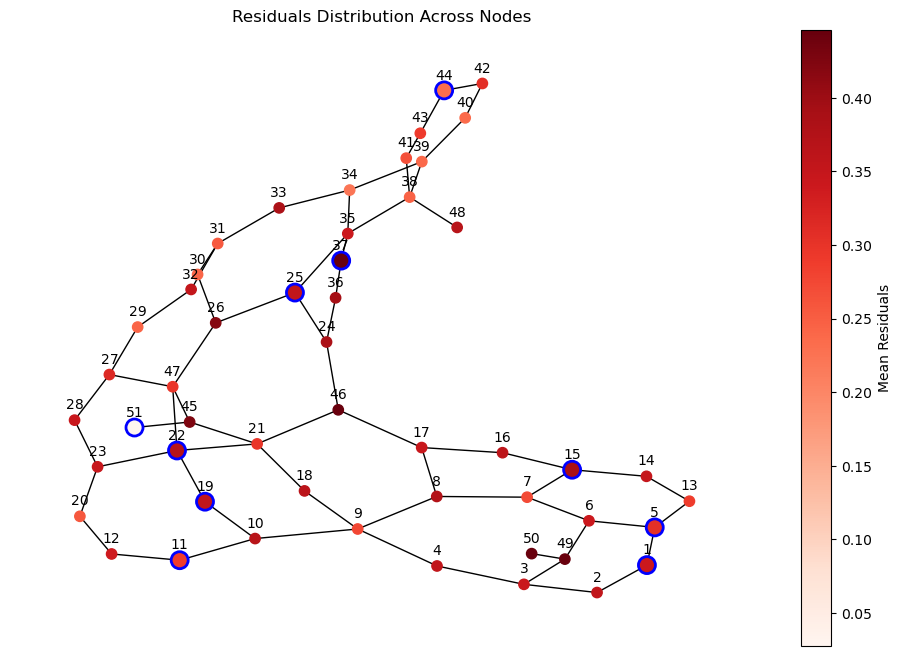

In [19]:
# 从DataFrame创建一个边列表
edges = list(zip(link_graph_df['start_node'], link_graph_df['end_node']))
G = nx.Graph()
# Convert float monitor nodes to string format
string_monitor = ['Node ' + str(int(node)) for node in float_monitor]

# Extract color values for monitor nodes
monitor_colors = [mean_residuals[node] for node in string_monitor]

plt.figure(figsize=(12, 8))
ax = plt.gca()

G.add_edges_from(edges)

colors = [mean_residuals[node-1] for node in G.nodes()]
pos = nx.spring_layout(G, k=0.35, iterations=100,seed = 35)

# 为所有节点绘制颜色
nx.draw_networkx_nodes(G, pos, node_size=55, node_color=colors, cmap=plt.cm.Reds, ax=ax)
# 为float_monitor节点绘制颜色，并加上黑色边框
nx.draw_networkx_nodes(G, pos, node_size=150,nodelist=float_monitor, node_color=monitor_colors, cmap=plt.cm.Reds, edgecolors='blue', linewidths= 2, ax=ax)
nx.draw_networkx_edges(G, pos, ax=ax)

# 添加标签
label_pos = {node: (x, y+0.05) for node, (x, y) in pos.items()}  # 将y坐标向上移动0.05单位
nx.draw_networkx_labels(G, label_pos, font_size=10, ax=ax)

plt.title("Residuals Distribution Across Nodes")
sm = plt.cm.ScalarMappable(cmap=plt.cm.Reds, norm=plt.Normalize(vmin=min(colors), vmax=max(colors)))
sm.set_array([])
plt.colorbar(sm, label='Mean Residuals', orientation='vertical')
plt.axis('off')
plt.show()